In [1]:
from tinyai import *

import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim,Tensor
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

set_output()
# toggle_mpl_cmap()

In [2]:
from IPython import get_ipython

def in_notebook():
    "Check if the code is running in a jupyter notebook"
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell': # Jupyter notebook, Spyder or qtconsole
            import IPython
            #IPython version lower then 6.0.0 don't work with output you update
            return IPython.__version__ >= '6.0.0'
        elif shell == 'TerminalInteractiveShell': return False  # Terminal running IPython
        else: return False  # Other type (?)
    except NameError: return False      # Probably standard Python interpreter
in_notebook()

True

In [3]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

def download_image(url):
    imgb = fc.urlread(face_url,decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float() / 255.

torch.Size([3, 256, 256])


<Axes: >

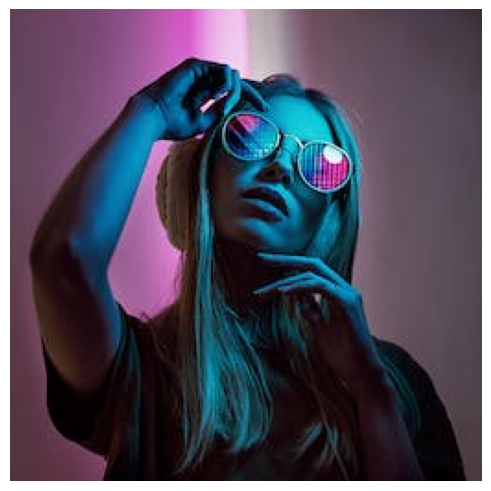

In [4]:
content_im = download_image(face_url).to(def_device)
print(content_im.shape)
show_image(content_im)

## Optimizing Images

In [5]:
class LengthDataset:
    def __init__(self, length=1):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return 0, 0


def get_dummy_dls(length=100):
    return DataLoaders(
        DataLoader(LengthDataset(length), batch_size=1),
        DataLoader(LengthDataset(length=1), batch_size=1),
    )

In [6]:
for b in get_dummy_dls(10).train:
    print(b)

[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]


In [7]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())

    def forward(self, x=0): return self.t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

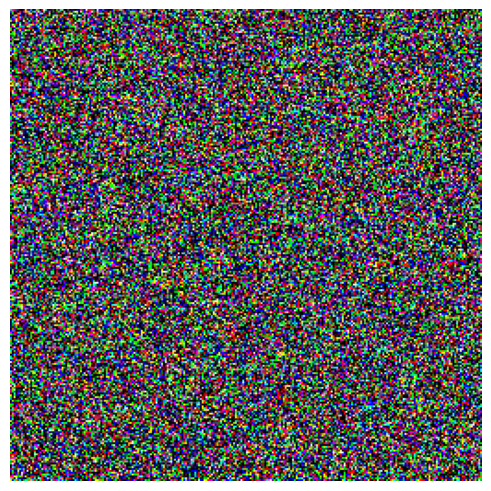

In [8]:
model = TensorModel(torch.randn_like(content_im))
show_image(model())

In [9]:
class ImageOptCB(AccelerateCB):
    def __init__(self):
        super().__init__(n_inp=0)

    def predict(self, learn):
        learn.preds = learn.model()

    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds)


crit = partial(F.mse_loss, target=content_im)

In [10]:
t = Trainer
t.default_cbs[1] = ImageOptCB()
learn = Trainer(model, get_dummy_dls(100), loss_func=crit)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/100 [00:00<?, ?it/s]

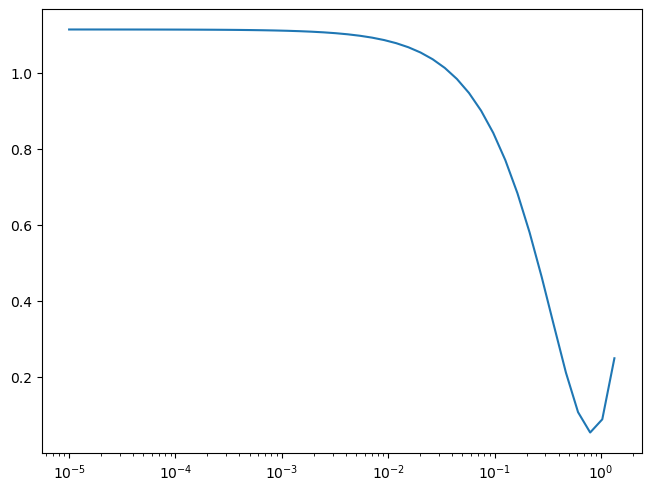

In [11]:
learn.lr_find()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Batch:   0%|          | 0/100 [00:00<?, ?it/s]

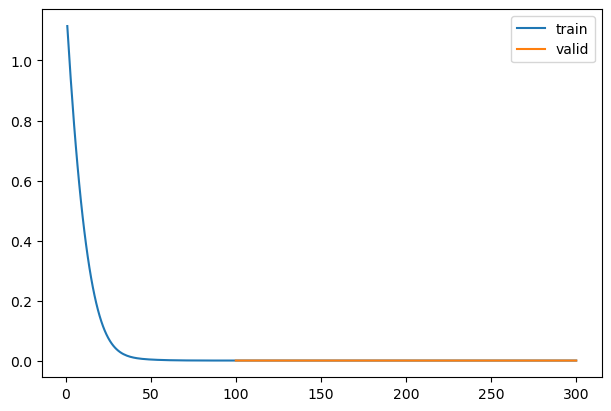

   epoch    train     loss
       0    train   0.1145
       0     eval   0.0000
       1    train   0.0000
       1     eval   0.0000
       2    train   0.0000
       2     eval   0.0000


In [12]:
learn.fit(3, lr=1e-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


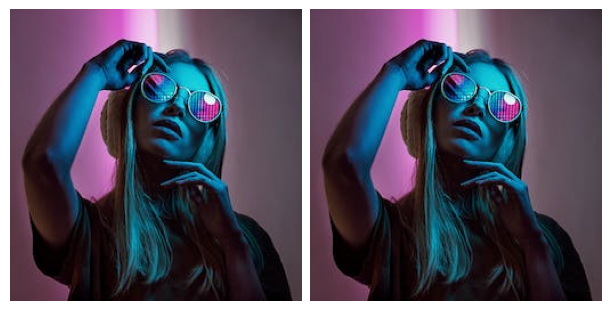

In [13]:
show_images([content_im, learn.model()])

## Log images as we go

In [14]:
from itertools import zip_longest

class ImageLogCB(Callback):
    order = PlotCB.order + 1

    def __init__(self, log_every=10):
        self.log_every = log_every
        self.images = []

    def after_batch(self, learn):
        if learn.iter % self.log_every == 0:
            self.images.append(to_cpu(learn.preds.clip(0, 1)))

    def after_fit(self, learn):
        fig, axs = get_grid(len(self.images))
        axs = axs.flatten()
        for im, ax in zip_longest(self.images, axs):
            show_image(im, ax=ax)
        fig.show()

In [15]:
t = Trainer
t.default_cbs[1] = ImageOptCB()
model = TensorModel(torch.randn_like(content_im))
learn = Trainer(model, get_dummy_dls(30), loss_func=crit)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Batch:   0%|          | 0/30 [00:00<?, ?it/s]

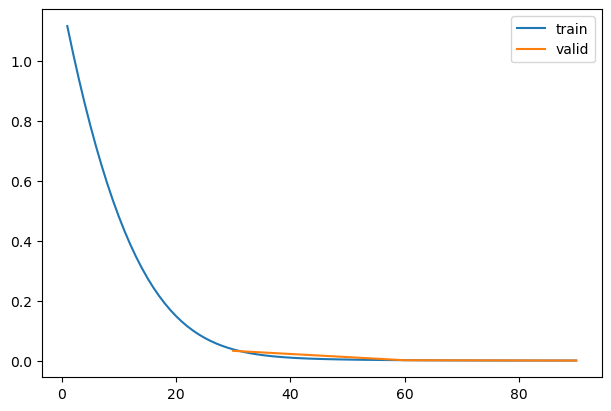

   epoch    train     loss
       0    train   0.3733
       0     eval   0.0325
       1    train   0.0088
       1     eval   0.0012
       2    train   0.0004
       2     eval   0.0001


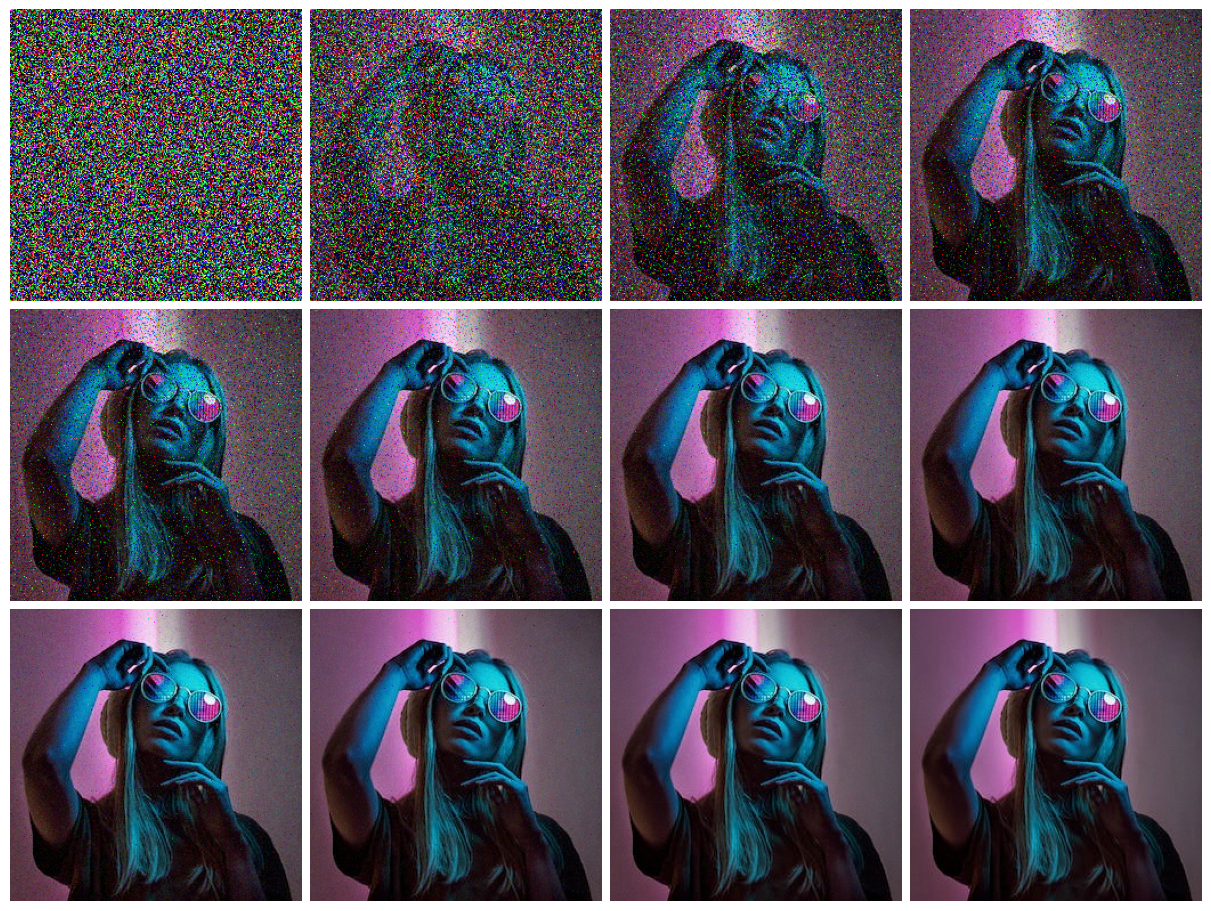

In [16]:
learn.fit(3, lr=1e-1, cbs=[ImageLogCB()])

## Getting images from VGG

In [17]:
import timm

In [18]:
timm.list_models("*vgg*")

['repvgg_a0',
 'repvgg_a1',
 'repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4',
 'repvgg_d2se',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [19]:
vgg16 = timm.create_model("vgg16", pretrained=True).to(def_device).features
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [20]:
from torchvision import transforms

normalize = transforms.Normalize(*IMAGENET_STATS)
norm_im = normalize(content_im)

mean, std = IMAGENET_STATS
norm_im_manual= ((content_im - tensor(mean, device=def_device)[:, None, None]) / tensor(std, device=def_device)[:, None, None])

torch.allclose(norm_im, norm_im_manual), norm_im.min(), norm_im.max(), norm_im.mean(), norm_im.mean(dim=(1,2))

(True,
 tensor(-2.118, device='cuda:0'),
 tensor(2.640, device='cuda:0'),
 tensor(-0.786, device='cuda:0'),
 tensor([-0.973, -0.962, -0.422], device='cuda:0'))

In [21]:
from torchvision import transforms

vgg16 = timm.create_model("vgg16", pretrained=True).to(def_device).features
normalize = transforms.Normalize(*IMAGENET_STATS)

def calc_features(content_im, target_layers=(18, 25)):
    feats = []
    target_modules = [x for i, x in enumerate(vgg16.modules()) if i in target_layers]

    def _f(h, mod, inp, outp):
        feats.append(outp.clone())


    with Hooks(target_modules, _f):
        vgg16(normalize(content_im))

    return feats

feats = calc_features(content_im)
[x.shape for x in feats]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

In [22]:
def calc_features2(imgs, target_layers=(18, 25)): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [23]:
len(feats), [x.shape for x in feats]

(2, [torch.Size([512, 32, 32]), torch.Size([512, 16, 16])])

In [24]:
[torch.allclose(i,j) for i,j in zip(calc_features(content_im), calc_features2(content_im))]

[False, False]

In [25]:
[(i.shape, j.shape) for i,j in zip(calc_features(content_im), calc_features2(content_im))]

[(torch.Size([512, 32, 32]), torch.Size([512, 32, 32])),
 (torch.Size([512, 16, 16]), torch.Size([512, 16, 16]))]

In [26]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [27]:
class ContentLossToTarget:
    def __init__(self, target_im, target_layers):
        self.target_im = target_im
        self.target_layers = target_layers
        with torch.inference_mode():
            self.target_feats = calc_features2(self.target_im, self.target_layers)
    
    def __call__(self, input_im):
        input_feats = calc_features2(input_im, self.target_layers)
        return sum((f1 - f2).pow(2).mean() for f1, f2 in zip(input_feats, self.target_feats))

loss_func_perceptial = ContentLossToTarget(content_im, target_layers=(1,6,))

In [28]:
t = Trainer
t.default_cbs[1] = ImageOptCB()
model = TensorModel(torch.randn_like(content_im))
learn = Trainer(model, get_dummy_dls(500), loss_func=loss_func_perceptial, opt_func=torch.optim.Adam)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

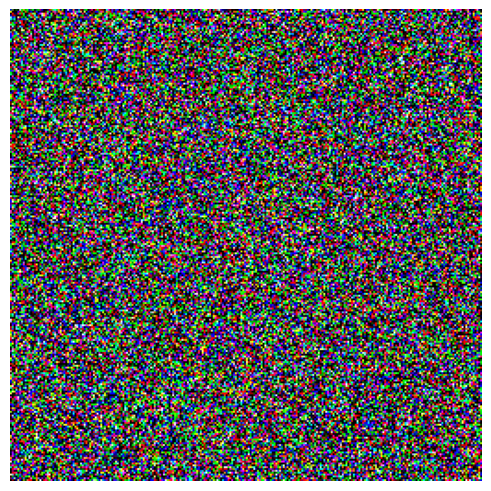

In [29]:
show_image(learn.model())

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/500 [00:00<?, ?it/s]

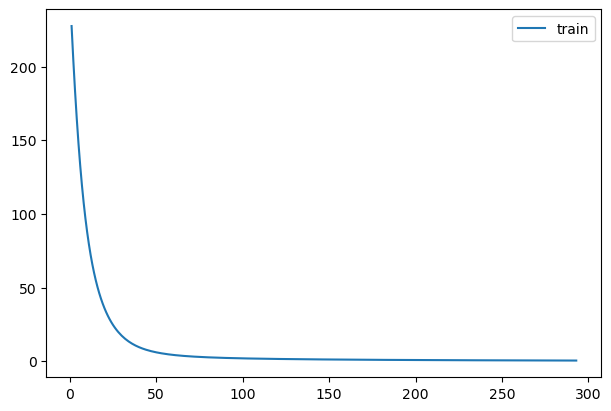

In [31]:
learn.fit(1, lr=4e-2, cbs=[ImageLogCB(30)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

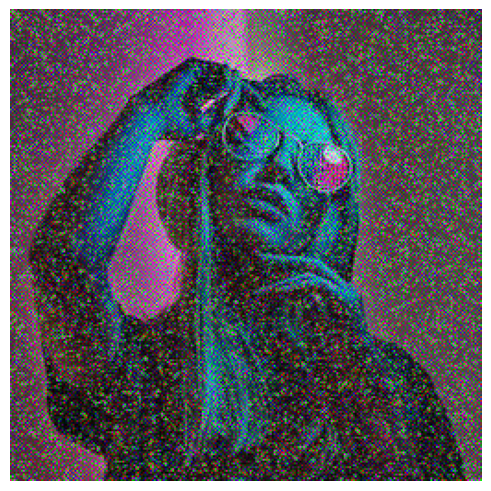

In [ ]:

show_image(learn.model())